# Проект 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:



*   В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
*   Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
*   Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.





# Задание 1

Retention – один из самых важных показателей в компании. **Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).**

Данные хранятся на яндекс.диске, ссылки для скачивания:

reg_data.csv – данные о времени регистрации https://disk.yandex.ru/d/_y1WylHbbVHhRw

auth_data.csv – данные о времени захода пользователей в игру https://disk.yandex.ru/d/DoRXITTlEui0vA

# Импорт необходимых библиотек

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import requests
from urllib.parse import urlencode
from operator import attrgetter
from scipy import stats
from scipy.stats import levene
from statsmodels.stats.proportion import proportions_ztest

In [7]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
df_urls = {'reg_data': 'https://disk.yandex.ru/d/_y1WylHbbVHhRw',
             'auth_data': 'https://disk.yandex.ru/d/DoRXITTlEui0vA'}

# Получаю ссылку для загрузки
for key, value in df_urls.items():
    final_url = base_url + urlencode(dict(public_key=value))
    response = requests.get(final_url)
    download_url = response.json()['href']
    # Загружю и сохраняю файл
    download_response = requests.get(download_url)
    with open(f'{key}.csv', 'wb') as f:
        f.write(download_response.content)

In [8]:
data_reg = pd.read_csv('reg_data.csv', sep=';')
data_auth = pd.read_csv('auth_data.csv', sep=';')

Сначала посмотрю на структуру данных и оценю, нужно ли проводить предобработку данных

In [9]:
data_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [10]:
data_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


По обоим наборам данных видно, что время регистрации и время аутентификации указано в формате timestamp, поэтому перевожу
данные в столбцах reg_ts и auth_ts в формат datetime

In [11]:
data_reg['reg_ts'] = pd.to_datetime(data_reg['reg_ts'], unit='s')

In [12]:
data_auth['auth_ts'] = pd.to_datetime(data_auth['auth_ts'], unit='s')

In [13]:
# Использую функцию describe, чтобы оценить первую и последние даты в наборе данных
data_reg.reg_ts.describe()

,reg_ts
count,1000000
mean,2019-01-24 12:12:34.523666688
min,1998-11-18 09:43:43
25%,2018-06-03 13:55:11.500000
50%,2019-07-30 02:35:25
75%,2020-04-01 16:28:40.500000
max,2020-09-23 15:17:24


In [15]:
def calculate_retention(start_date, end_date):
    """
    Функция для расчета коэффициента удержания пользователей (Retention) за указанный период.

    Параметры:
    start_date (str): Дата начала периода учета в формате 'YYYY-MM-DD'.
    end_date (str): Дата конца периода учета в формате 'YYYY-MM-DD'.

    Возвращает:
    tuple:
        - retention_matrix (DataFrame): Матрица удержания пользователей по когортам.
        - cohort_size (Series): Размеры когорт.
    """

    reg_copy = data_reg[(data_reg['reg_ts'] >= start_date) & (data_reg['reg_ts'] <= end_date)]
    auth_copy = data_auth[(data_auth['auth_ts'] >= start_date) & (data_auth['auth_ts'] <= end_date)]

    data_merge = reg_copy.merge(auth_copy, on='uid', how='left')

    data_merge['period_day'] = data_merge['auth_ts'].dt.to_period('D')

    data_merge['cohort'] = data_merge.groupby('uid')['auth_ts'].transform('min').dt.to_period('D')

    data_merge['period_number_day'] = np.floor((data_merge.period_day - data_merge.cohort).apply(attrgetter('n')))

    df_cohort = data_merge.groupby(['cohort', 'period_number_day']).agg(n_users=('uid', 'nunique')).reset_index()

    cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number_day', values='n_users')

    cohort_size = cohort_pivot.iloc[:, 0]

    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

    return retention_matrix, cohort_size

# Реализация функции
start_date = '2020-09-01'
end_date = '2020-09-23'

retention_matrix, cohort_size = calculate_retention(start_date, end_date)
retention_matrix

period_number_day,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2020-09-01,1.0,0.020177,0.040984,0.042245,0.046028,0.064313,0.056116,0.064313,0.040984,0.054224,...,0.048550,0.054855,0.042875,0.044136,0.043506,0.050441,0.041614,0.043506,0.035939,0.043506
2020-09-02,1.0,0.025189,0.039043,0.046599,0.056675,0.062343,0.071159,0.062972,0.048489,0.040932,...,0.054786,0.043451,0.049748,0.052897,0.041562,0.048489,0.039043,0.037154,0.046599,NaN
2020-09-03,1.0,0.023256,0.054054,0.047140,0.065368,0.069767,0.085481,0.063482,0.054683,0.062854,...,0.058454,0.059711,0.054683,0.053426,0.043997,0.048397,0.046512,0.054683,NaN,NaN
2020-09-04,1.0,0.020088,0.036409,0.036409,0.051475,0.064030,0.072819,0.049592,0.053358,0.043315,...,0.043315,0.055869,0.043942,0.045198,0.045198,0.042687,0.047709,NaN,NaN,NaN
2020-09-05,1.0,0.027569,0.039474,0.046366,0.054511,0.058897,0.074561,0.048872,0.050752,0.054511,...,0.045739,0.053885,0.045113,0.051378,0.044486,0.047619,NaN,NaN,NaN,NaN
2020-09-06,1.0,0.031270,0.043152,0.054409,0.056285,0.058787,0.068168,0.060663,0.058161,0.055034,...,0.053784,0.051907,0.055034,0.045654,0.048155,NaN,NaN,NaN,NaN,NaN
2020-09-07,1.0,0.029357,0.042473,0.053716,0.050593,0.063710,0.073079,0.052467,0.041224,0.056215,...,0.045597,0.050593,0.042473,0.050593,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-08,1.0,0.017456,0.039277,0.039277,0.048628,0.076060,0.075436,0.066085,0.051746,0.051746,...,0.059227,0.051746,0.047382,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-09,1.0,0.017424,0.032358,0.046671,0.057250,0.066584,0.057250,0.059116,0.043559,0.050404,...,0.047915,0.048538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Функция подсчета Retention готова.

Добавляю визуализацию показателя Retention

<ipython-input-16-afa7275de1da>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  white_cmap = plt.cm.get_cmap('Blues', 1)


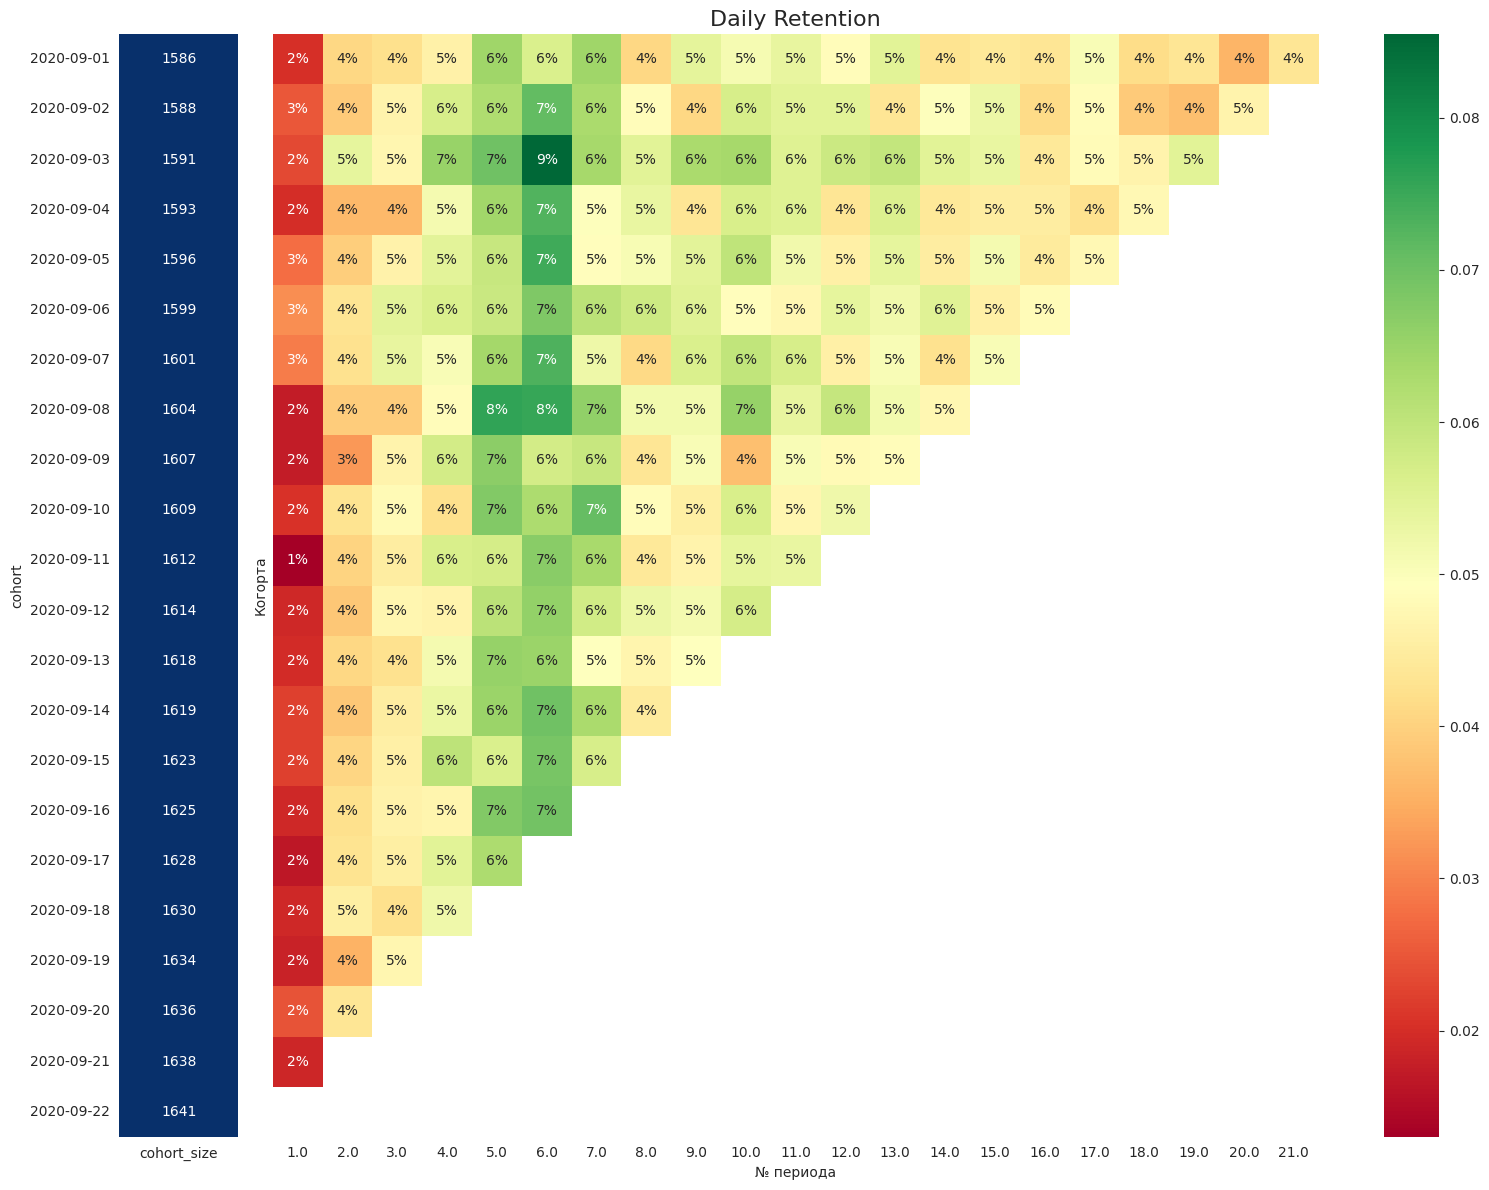

In [16]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Создаю маску, в которой не будет Retention за нулевой день, т.к. в этот день показатель всегда 100%
    mask = retention_matrix.iloc[:, 1:].isnull()

    # Тепловая карта для коэффициентов удержания без учета нулевого дня, т.к. там всегда 100%
    sns.heatmap(retention_matrix.iloc[:, 1:],
                mask=mask,
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Daily Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = plt.cm.get_cmap('Blues', 1)
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

**Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?**

Данные хранятся на яндекс.диске, ссылка для скачивания:

Проект__1_Задание_2.csv - https://disk.yandex.ru/d/SOkIsD5A8xlI7Q

In [17]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
file_url = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

final_url = base_url + urlencode(dict(public_key=file_url))

response = requests.get(final_url)

download_url = response.json()['href']

# Загружю и сохраняю файл
download_response = requests.get(download_url)

task_2 = pd.read_csv(download_url, sep=';')

In [18]:
# Создаю новый датафрейм, где данные только о платящих пользователях
task_2_paying = task_2.query("revenue > 0")

In [19]:
# Создаю новый датафрейм с данными только о пользователях из контрольной группы для будущих расчетов
group_a = task_2.query("testgroup == 'a'")

In [20]:
# Создаю новый датафрейм с данными только о пользователях из тестовой группы для будущих расчетов
group_b = task_2.query("testgroup == 'b'")

In [21]:
# Подсчитываю количество платящих пользователей в контрольной группе для будущих расчетов ARPPU
paying_users_a = group_a.query("revenue > 0").user_id.nunique()

In [22]:
# Подсчитываю количество платящих пользователей в тестовой группе для будущих расчетов ARPPU
paying_users_b = group_b.query("revenue > 0").user_id.nunique()

In [23]:
# Подсчитываю общее количество пользователей в контрольной группе для расчета ARPU
users_a = group_a.user_id.nunique()

In [24]:
# Подсчитываю общее количество пользователей в тестовой группе для расчета ARPU
users_b = group_b.user_id.nunique()

In [25]:
# Создаю новый датафрейм с расчетом общих доходов по каждой группе
revenue_total = task_2.groupby('testgroup', as_index=False) \
                      .agg({'revenue' : 'sum'})
revenue_total

,testgroup,revenue
0,a,5136189
1,b,5421603


In [26]:
# Рассчитываю разницу в доходах в абсолютных значениях между тестовой и контрольной группами
revenue_total.set_index('testgroup', inplace=True)
difference = revenue_total['revenue'].diff().iloc[-1]

In [27]:
difference

np.float64(285414.0)

In [28]:
# Создаю 2 Series для проверки гомогенности дисперсии доходов по всем пользователям в выборках
control_group = task_2[task_2['testgroup'] == 'a']['revenue']
test_group = task_2[task_2['testgroup'] == 'b']['revenue']

In [29]:
# Создаю 2 Series для проверки гомогенности дисперсии доходов по платящим пользователям в выборках
control_group_paying = task_2[(task_2['testgroup'] == 'a') & (task_2['revenue'] > 0)]['revenue']
test_group_paying = task_2[(task_2['testgroup'] == 'b') & (task_2['revenue'] > 0)]['revenue']

In [30]:
# Использую тест Левене для проверки гомогенности дисперсий по всем пользователям
stat, p_value = levene(control_group, test_group)

print(f'Статистика теста Левене: {stat}, P-значение: {p_value}')

Статистика теста Левене: 0.3896289474701388, P-значение: 0.5324948591043842


In [31]:
# Использую тест Левене для проверки гомогенности дисперсий по платящим пользователям
stat, p_value = levene(control_group_paying, test_group_paying)

print(f'Статистика теста Левене: {stat}, P-значение: {p_value}')

Статистика теста Левене: 80.85567421779912, P-значение: 3.779689868667878e-19


По результатам тестов при проверке гомогенности дисперсий в исходных выборках p-value равняется 0.53, что указывает на то, что у нас нет оснований полагать, что дисперсии в наших группах различаются, а значит далее, при проведении T-test'а для этой же выборки, мы будем использовать параметр equal_var как True. При проверке гомогенности дисперсий только по платящим пользователям p-value сильно ниже 0,05, поэтому предполагаем, что дисперсии в данных выборках различаются, поэтому при проведении T-test'a будем использовать equal_var как False.

In [32]:
# Создаю два Series, в которых будут указаны доходы от каждого пользователя в группе
# Это нужно для проведения T-теста и оценки, имеют ли данные о доходах в 2ух группах стат. значимые различия
revenue_a = task_2[task_2['testgroup'] == 'a']['revenue']
revenue_b = task_2[task_2['testgroup'] == 'b']['revenue']

Далее провожу T-test для оценки того, есть ли статистически значимые различия в данных о доходах между нашими группами.

In [33]:
stats.ttest_ind(revenue_a, revenue_b, equal_var=True)

TtestResult(statistic=np.float64(-0.6242026493616787), pvalue=np.float64(0.532494858971837), df=np.float64(404768.0))

Так же провожу T-test для этих же групп пользователей, но без учета неплатящих пользователей.

In [34]:
# По аналогии с кодом ранее, создаю Series с доходами по каждому платящему пользователю
revenue_a_paying = task_2_paying[task_2_paying['testgroup'] == 'a']['revenue']
revenue_b_paying = task_2_paying[task_2_paying['testgroup'] == 'b']['revenue']

In [35]:
stats.ttest_ind(revenue_a_paying, revenue_b_paying, equal_var=False)

TtestResult(statistic=np.float64(-1.644630266430084), pvalue=np.float64(0.10020780398916015), df=np.float64(1943.4815217434643))

# По результатам двух Т-тестов видим, что во всех случаях значение p-value значительно выше, чем 0,05, поэтому мы не можем отвергнуть нулевую гипотезу нашего А/Б теста о том, что статистически значимых различий в группах нет. Отсюда вывод, что, несмотря на то, что ARPU в тестовой группе выше на 5%, это не означает, что разница в доходах между группами статистически значима.

In [36]:
# Использую describe, чтобы оценить разброс значений Revenue в контрольной группе
group_a.revenue.describe()

,revenue
count,202103.000000
mean,25.413720
std,920.768137
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,37433.000000


In [37]:
# Использую describe, чтобы оценить разброс значений Revenue в тестовой группе
group_b.revenue.describe()

,revenue
count,202667.000000
mean,26.751287
std,287.324162
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,4000.000000


Смотря на основные статистические показатели в разрезе по группам видим, что у групп пользователей крайне большие различия в стандартном отклонении (920,77 в контрольной группе и 287,32 в тестовой) и в максимальных значениях (37433 в контрольной группе и 4000 в тестовой группе). Такие различия в данных вызывают сомнения в корректности проведенного эксперимента. Вероятно, дизайн эксперимента нарушен и сплитование проведено некорректно. Вероятно, необходимо пересобрать группы и повторно запустить эксперимент.

Далее я рассчитал метрики ARPU, ARPPU и CR, чтобы продемонстрировать понимание этих метрик.

In [38]:
# ARPU для контрольной группы считаю, как отношение общего дохода в группе к числу пользователей в этой группе
arpu_a = revenue_total.revenue[0] / users_a

<ipython-input-38-dfe97c413b7b>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arpu_a = revenue_total.revenue[0] / users_a


In [39]:
arpu_a

np.float64(25.413719736965806)

In [40]:
# ARPU для тестовой группы считаю, как отношение общего дохода в тестовой группе к числу пользователей в этой группе
arpu_b = revenue_total.revenue[1] / users_b

<ipython-input-40-b2e5ea0bacf5>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arpu_b = revenue_total.revenue[1] / users_b


In [41]:
arpu_b

np.float64(26.75128659327863)

In [42]:
# ARPPU для контрольной группы считаю, как отношение общего дохода в группе к числу платящих пользователей в этой группе
arppu_a = revenue_total.revenue[0] / paying_users_a

<ipython-input-42-cf816f98db71>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arppu_a = revenue_total.revenue[0] / paying_users_a


In [43]:
arppu_a

np.float64(2663.9984439834025)

In [45]:
# ARPPU для тестовой группы считаю, как отношение общего дохода в группе к числу платящих пользователей в этой группе
arppu_b = revenue_total.revenue[1] / paying_users_b

<ipython-input-45-f2ae0f8a3728>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arppu_b = revenue_total.revenue[1] / paying_users_b


In [46]:
arppu_b

np.float64(3003.6581717451522)

In [47]:
# Считаю, на сколько % ARPPU в тестовой группе больше, чем в контрольной группе
arppu_diff_percent = arppu_b / arppu_a * 100 - 100

In [48]:
arppu_diff_percent

np.float64(12.749997227996346)

In [50]:
# Считаю CR для контрольной группы, как отношение числа платящих пользователей к общему числу пользователей в группе
cr_a = paying_users_a / users_a * 100

In [51]:
cr_a

0.9539690157988748

In [52]:
# Считаю CR для тестовой группы, как отношение числа платящих пользователей к общему числу пользователей в группе
cr_b = paying_users_b / users_b * 100

In [53]:
cr_b

0.8906235351586593

In [54]:
# Считаю, на сколько конверсия в контрольной группе выше, чем в тестовой
cr_diff = cr_a - cr_b

In [55]:
cr_diff

0.0633454806402155

In [56]:
# Создаю новый датафрейм, в котором будет общее и конверсионное количество пользователей по группам
conversion = task_2.groupby('testgroup').agg(
    total_users=('user_id', 'count'),
    converted_users=('revenue', lambda x: (x > 0).sum())
)

In [57]:
conversion

,total_users,converted_users
testgroup,,
a,202103,1928
b,202667,1805


In [58]:
# Извлекаю данные по группам и пользователям в отдельные переменные для проведния Z-теста
all_group_a = conversion.loc['a', 'total_users']
all_group_b = conversion.loc['b', 'total_users']
converted_a = conversion.loc['a', 'converted_users']
converted_b = conversion.loc['b', 'converted_users']

In [59]:
# Провожу Z-тест для оценки наличия статистически значимой разницы между конверсиями
z_score, p_value = proportions_ztest([converted_a, converted_b], [all_group_a, all_group_b])
print(f'Z-score: {z_score}, P-value: {p_value}')

Z-score: 2.108028495889841, P-value: 0.035028524642854865


По итогам статистического теста конверсии p-value меньше 0,05, что говорит о наличие статистически значимых различий в конверсиях между группами. Однако, как уже было описано ранее, есть сомнения в корректности проведения А/Б теста в целом.

По итогам расчетов получилось, что ARPU в тестовой группе выше на 5%, чем в контрольной, ARPPU выше на 12,7%, при этом CR в контрольной группе выше на 0,06%, чем в тестовой. Однако, проведенные выше T-test'ы и крайне большие различия между стандартными отклонениями и максимальными значениями в группах по revenue не позволяют нам определить эти различия в метриках как статистически значимые, поэтому по проведенному А/Б тесту мы не можем определить лучший набор акционных предложений.

# Задание 3:

# Для оценки результата последнего прошедшего события я бы использовал следующие метрики роста:

1) <b>Уровень участия игроков в ивенте</b> - рассчитывал бы как отношение общего числа игроков за время ивента к числу игроков, которые участвовали в тематических событиях. Эта метрика показала бы нам, какой % от всей нашей аудитории был заинтересован в ивенте;

2) <b>Retention</b> - здесь оценил бы, вырастет ли Retention rate у игроков во время ивента, т.к., скорее всего, изначально мы предполагаем, что тематические игровые ивенты должны повышать активность игроков, что будет заметно в изменениях Retention, а если этого не происходит, то, вероятно, наш ивент не совсем удачный;

3) <b>Churn rate</b> - здесь оценил бы, сократится ли данная метрика, учитывая, что в игре появилось новое, вероятно, привлекательное для игроков событие;

4) <b>ARPU и ARPPU</b> - предполагаю, что проходить уровни либо получать подсказки/бонусы/бустеры и т.д. можно будет за счет внутриигровых покупок, поэтому логично рассчитать эти 2 метрики во время ивента, т.к., очевидно, что мы ожидаем рост этих метрик;

5) <b>Прирост новых платящих пользователей</b> - здесь, думаю, было бы логично оценить, насколько % вырастет количество платящих пользователей в нашей игре. То есть, какой процент ранее не платящих пользователей станут платящими именно во время ивента.

# И эти метрики продукта:

1) <b>Среднее время на прохождение уровня/всего ивента</b> - здесь оценил бы, сколько в среднем времени игроки тратят на прохождение того или иного уровня или на весь ивент сразу. Эта метрика поможет оценить нам "сложность" ивента. Возможно, наш ивент окажется либо слишком затянутым и сложным, либо наоборот слишком легким;

2) <b>Уровень прохождения ивента игроками</b> - эта метрика выглядела бы как % игроков, которые дошли до определенного этапа ивента. Например, если у нас 5 уровней в ивенте, то определить, какой % игроков прошел каждый из 5 уровней и сколько всего пользователей прошли весь ивент. Эта метрика тоже поможет оценить "сложность" ивента и заинтересованность пользователей в нем;

3) <b>Отзыв пользователей об ивенте</b> - добавить небольшой опрос об удовлетворенности ивентом после прохождения определенного количества уровней, либо для каждого пользователя, кто хоть раз поучаствовал в ивенте, и оценить их ответы с оценками ивента.

# Метрики роста после усложнения механики событий:

1) <b>Churn rate</b> - предполагаю, что для части аудитории такая механика "отката" уровней назад может оказаться неприятной, и, вполне вероятно, что коэффициент оттока пользователей увеличится;

2) <b>ARPU и ARPPU</b> - оценить, побудит ли усложнение ивента игроков совершать внутриигровые покупки активнее;

# Метрики продукта после усложнения механики событий:

1) <b>Процент пользователей, которые бросили ивент после одного "отката" назад</b> - здесь оценил бы, какой % игроков перестанут заходить в ивент после одной неудачной попытки. Эта метрика покажет нам, как наши игроки отреагировали на такую механику. Предположу, что, например, эта метрика при значении в 50% говорила бы нам о том, что наш эксперимент с усложнением ивента неудачный, т.к. половина игроков перестанет участвовать в ивенте после первой неудачи;

2) <b>Отзыв пользователей об ивенте</b> - добавить небольшой опрос об удовлетворенности ивентом после прохождения определенного количества уровней, либо для каждого пользователя, кто хоть раз поучаствовал в ивенте, и оценить их ответы с оценками ивента. Если механика отката уровней была добавлена после обычного ивента с уровнями, то оценить, вырасло ли количество негативных отзывов об ивенте, или же пользователям наоборот понравилось сложность в прохождении ивента.